In [1]:
import pandas as pd
import boto3
import sagemaker
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()
print(bucket)

sagemaker-us-east-1-077458658795


In [3]:
# load data

data_dir = 'capstone_data'

prefix = 'capstone_project'

# already ran
# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [4]:
# create model
input_size=16
batch_size = 100
from sagemaker.pytorch import PyTorch
model = PyTorch(entry_point='train.py',
                source_dir='lstm',
                role=role,
                train_instance_count=1, 
                train_instance_type='ml.c4.xlarge',
                sagemaker_session=sagemaker_session,
                framework_version='1.8.1',
                py_version='py3',
                hyperparameters={
                                 'sequence-size': 16,
                                 'input-size': input_size,
                                 'hidden-dim': 4,
                                 'batch-size': batch_size,
                                 'epochs':30 
                                }
               )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [5]:
%%time

# Train your estimator on S3 training data
model.fit({'train': f's3://{bucket}/{prefix}'})

2021-07-23 22:02:02 Starting - Starting the training job...
2021-07-23 22:02:29 Starting - Launching requested ML instancesProfilerReport-1627077722: InProgress
...
2021-07-23 22:03:00 Starting - Preparing the instances for training............
2021-07-23 22:04:59 Downloading - Downloading input data
2021-07-23 22:04:59 Training - Downloading the training image...
2021-07-23 22:05:30 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-23 22:05:27,395 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-07-23 22:05:27,397 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-07-23 22:05:27,407 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-23 22:05:30,483 sagemaker_pytorch_container.training INFO     Invoking user training script

Epoch: 5, Loss: 0.013516449396830109
Epoch: 6, Loss: 0.013562843331425083
Epoch: 7, Loss: 0.013597584513869757
Epoch: 8, Loss: 0.013617150620451535
Epoch: 9, Loss: 0.013630775218850678
Epoch: 10, Loss: 0.01364032098155638
Epoch: 11, Loss: 0.013647298557881379
Epoch: 12, Loss: 0.013652551629947442
Epoch: 13, Loss: 0.013656604818110778
Epoch: 14, Loss: 0.0136598009972438
Epoch: 15, Loss: 0.013662374645443351
Epoch: 16, Loss: 0.013664470782686927
Epoch: 17, Loss: 0.013666207305945907
Epoch: 18, Loss: 0.01366766247189265

2021-07-23 22:05:57 Uploading - Uploading generated training modelEpoch: 19, Loss: 0.013668899639566062
Epoch: 20, Loss: 0.01366995632997714
Epoch: 21, Loss: 0.013670867089372636
Epoch: 22, Loss: 0.013671660508297271
Epoch: 23, Loss: 0.0136723562291908
Epoch: 24, Loss: 0.013672975910594687
Epoch: 25, Loss: 0.013673522654271714
Epoch: 26, Loss: 0.013674017306501892
Epoch: 27, Loss: 0.013674455770700606
Epoch: 28, Loss: 0.013674854339721302
Epoch: 29, Loss: 0.01367521138374

In [6]:
print(model.model_data)

s3://sagemaker-us-east-1-077458658795/pytorch-training-2021-07-23-22-02-02-040/output/model.tar.gz


In [7]:
%%time

# uncomment, if needed
#model_data, role, entry_point, framework_version=None, py_version=None
from sagemaker.pytorch import PyTorchModel
deploy_info = PyTorchModel(entry_point='predict.py',
                           source_dir='lstm',
                model_data=model.model_data,
                role=role,
                framework_version='1.8.1',
                py_version='py3'
               )


CPU times: user 3.78 ms, sys: 492 µs, total: 4.27 ms
Wall time: 26.8 ms


In [16]:
# test model
import numpy as np
import os
# read in test data, assuming it is stored locally
test_lstm = pd.read_csv(os.path.join(data_dir, "test_lstm.csv"), header=None, names=None)
# labels are in the first column
test_y = test_lstm.iloc[:,0]
test_x = np.reshape(test_lstm.drop([0], axis=1).iloc[:,:input_size].values, (-1, input_size))
print('y')
print(test_y)
print(test_x.shape)

y
0      0.0977
1      0.0915
2      0.0922
3      0.0922
4      0.0952
        ...  
498    0.1267
499    0.1265
500    0.1343
501    0.1482
502    0.1378
Name: 0, Length: 503, dtype: float64
(503, 16)


In [9]:
# deploy your model to create a predictor
predictor = deploy_info.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------------!

In [10]:
!pip install torch

     |████████████████████████████████| 831.4 MB 3.3 kB/s  eta 0:00:01    |█▋                              | 42.4 MB 17.9 MB/s eta 0:00:45     |██████████████████████          | 569.0 MB 54.2 MB/s eta 0:00:05
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [11]:
import torch
import numpy as np
# construct input to model
test_y_preds = []
for i in range(0, test_y.size-16):
    model_in = np.reshape(test_x[i:i+16], (1, 16, input_size))
    if i <= 2:
        print(model_in)
    test_y_preds.append(predictor.predict(model_in).squeeze())

preds = np.reshape(np.array(test_y_preds), (1, -1))
    
print(preds[0][:100])
print(len(preds[0]))

[[[0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972 0.1003 0.0953 0.0942
   0.1049 0.1018 0.0992 0.0934 0.0958 0.1016]
  [0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972 0.1003 0.0953
   0.0942 0.1049 0.1018 0.0992 0.0934 0.0958]
  [0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972 0.1003
   0.0953 0.0942 0.1049 0.1018 0.0992 0.0934]
  [0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972
   0.1003 0.0953 0.0942 0.1049 0.1018 0.0992]
  [0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962
   0.0972 0.1003 0.0953 0.0942 0.1049 0.1018]
  [0.0952 0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099
   0.0962 0.0972 0.1003 0.0953 0.0942 0.1049]
  [0.1008 0.0952 0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025
   0.099  0.0962 0.0972 0.1003 0.0953 0.0942]
  [0.0982 0.1008 0.0952 0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047
   0.1025 0.099  0.0962 0.0972 0.1003 0.0953]
  [0.0988 0.0982 0.1008 0.0952 0.0922 0.0922 0.09

In [12]:
# transform back:
y_orig = 100 * test_lstm[0][:len(preds[0])]
y_pred = pd.Series(100 * preds[0])

In [13]:
rmse = mean_squared_error(y_orig, y_pred, squared=False)
print(rmse)

4.121525740343911


Text(0.5, 1.0, 'LSTM - Predicted vs Actual VIX Prices During Test Period')

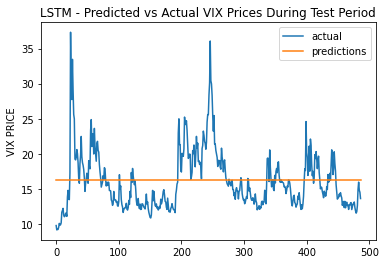

In [14]:
y_orig.plot(label="actual")
y_pred.plot(label="predictions")
plt.legend(loc="upper right")
plt.ylabel('VIX PRICE')
plt.title('LSTM - Predicted vs Actual VIX Prices During Test Period')

In [15]:
predictor.delete_endpoint()